In [1]:
# 1-1. 데이터 가져오기 

import pandas as pd 
import matplotlib.pyplot as plt 


socar = pd.read_csv('../../0. raw_data/insurance_fraud_detect_data.csv')
socar 

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,...,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,...,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,...,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,...,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,...,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,...,1209410,1,0,0,2,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,2,0,2,0,2,0,100,2,0,...,0,1,1,0,1,0,0,0,-1,0
15996,0,2,0,2,1,4,0,100,1,1,...,0,2,1,0,1,0,0,0,-1,0
15997,0,2,1,2,0,4,0,100,1,0,...,0,0,0,0,1,0,0,0,-1,1
15998,0,2,0,2,0,2,0,100,2,0,...,0,4,1,0,1,0,0,0,-1,0


In [2]:
df = socar.copy()

# 데이터 분리
- train / test 
- train / valid

In [10]:
X_ftr = df.drop('fraud_YN',axis=1)
y_tgt = df[['fraud_YN','test_set']]

In [12]:
y_tgt

,fraud_YN,test_set
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
...,...,...
15995,0,0
15996,0,0
15997,0,1
15998,0,0


In [17]:
X_train = X_ftr[X_ftr['test_set']==0]
X_test = X_ftr[X_ftr['test_set']==1]
y_train = y_tgt[y_tgt['test_set']==0].drop('test_set', axis=1)
y_test = y_tgt[y_tgt['test_set']==1].drop('test_set', axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12879, 24), (3121, 24), (12879, 1), (3121, 1))

In [20]:
# 데이터 불균형 정도 확인 

tmp = np.unique(y_train, return_counts=True)[1]
tmp[1] / len(y_train) *100

0.26399565183632273

In [24]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1] / len(y_test) *100

0.2242870874719641

In [43]:
# 성능을 return 하는 함수 

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    # confusion = confusion_matrix(y_test, pred) #오차행렬
    accuracy = accuracy_score(y_test,pred) # 정확도 
    precision = precision_score(y_test,pred) # 정밀도
    recall = recall_score(y_test,pred) # 재현율 
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred)
    return accuracy, precision, recall, f1, roc_auc
    # print('오차행렬')
    # print(confusion)

    # print('정확도 : {}, 정밀도 : {}, 재현률 : {}, f1 : {}, AUC : {}'.format(accuracy, precision, recall, f1, roc_auc))

In [44]:
# 모델의 성능과 DF 반환 

def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

# 다수의 모델 성능을 정리하여 DF 

def get_result_df(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'precision', 'recall', 'f1', 'roc']
    tmp = []
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [46]:
# 성능 확인 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# 모델 객체 생성 
lr_clf = LogisticRegression(random_state=11)
dt_clf = DecisionTreeClassifier(random_state=11, max_depth=4)
rf_clf = RandomForestClassifier(random_state=11, n_jobs = -1, n_estimators= 100 )
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)

# 학습 진행 
models=[lr_clf,dt_clf,rf_clf,lgbm_clf] 
model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM']
results = get_result_df(models, model_names, X_train, y_train, X_test, y_test)

In [47]:
results

,Accuracy,precision,recall,f1,roc
LogiReg,0.997757,0.0,0.0,0.0,0.500000
DecisionTree,0.997116,0.0,0.0,0.0,0.499679
RandomFore,0.997757,0.0,0.0,0.0,0.500000
LGBM,0.997757,0.0,0.0,0.0,0.500000


## 1차 분석 
- 정확도가 높은 반면 정밀도, 재현율에 대한 성능 측정 불가
- 불균형한 데이터의 영향이 큰 것으로 판단 

## SMOTE 오버샘플링 

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape

((12879, 24), (25690, 24))

In [49]:
# 데이터의 불균형이 개선됨 
tmp = np.unique(y_train_over, return_counts=True)[1]
tmp[1] / len(y_train) *100

99.73600434816368

In [51]:
# 학습 진행 
models=[lr_clf,dt_clf,rf_clf,lgbm_clf] 
model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM']
results = get_result_df(models, model_names, X_train_over, y_train_over
, X_test, y_test)

In [52]:
# 결과 
results

,Accuracy,precision,recall,f1,roc
LogiReg,0.279398,0.00222,0.714286,0.004427,0.496353
DecisionTree,0.813201,0.00000,0.000000,0.000000,0.407514
RandomFore,0.996475,0.00000,0.000000,0.000000,0.499358
LGBM,0.992310,0.00000,0.000000,0.000000,0.497270


# Trial #2 

<AxesSubplot:>

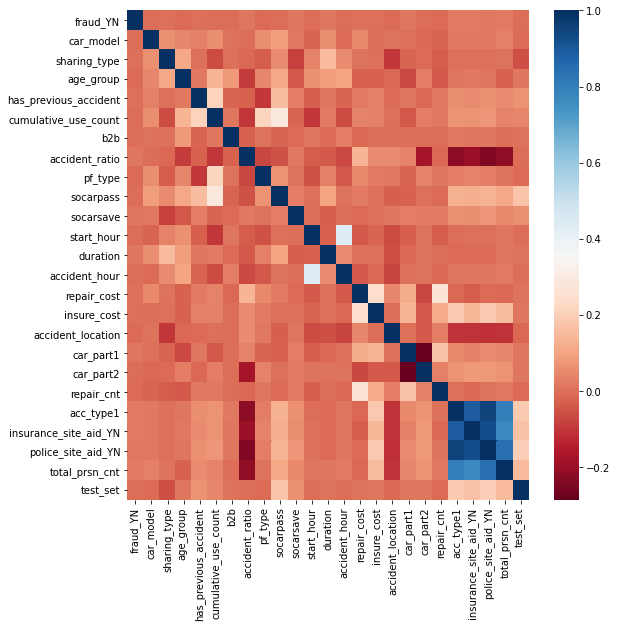

In [54]:
# 피쳐의 상관관계 확인 

import seaborn as sns
plt.figure(figsize=(9,9))
corr = socar.corr()
sns.heatmap(corr, cmap='RdBu')

<AxesSubplot:xlabel='repair_cnt'>

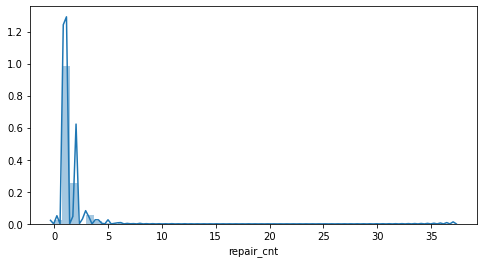

In [55]:
import seaborn as sns 
plt.figure(figsize=(8,4))

sns.distplot(socar['repair_cnt'])

In [57]:
socar['repair_cnt'].value_counts()

1     11682
2      2990
3       622
0       271
4       230
5        92
6        72
7        17
8        10
10        3
11        3
12        2
9         2
18        1
20        1
37        1
15        1
Name: repair_cnt, dtype: int64

In [64]:
# 로그 변환하여 스케일링

# 로그 변환 함수 
def get_preprocessed_df(df=None):
    df_copy = socar.copy()
    amount_n = np.log1p(df_copy['repair_cnt'])
    df_copy.insert(0, 'repair_cnt_scaled', amount_n)
    df_copy.drop(['repair_cnt'],axis=1, inplace=True)
    return df_copy

# 다시 

In [65]:
socar

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,...,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,...,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,...,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,...,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,...,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,...,1209410,1,0,0,2,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,2,0,2,0,2,0,100,2,0,...,0,1,1,0,1,0,0,0,-1,0
15996,0,2,0,2,1,4,0,100,1,1,...,0,2,1,0,1,0,0,0,-1,0
15997,0,2,1,2,0,4,0,100,1,0,...,0,0,0,0,1,0,0,0,-1,1
15998,0,2,0,2,0,2,0,100,2,0,...,0,4,1,0,1,0,0,0,-1,0


In [159]:
df = socar.copy()
df.drop(columns = ['test_set'], inplace =True)
df.tail()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,...,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt
15995,0,2,0,2,0,2,0,100,2,0,...,0.00000,0,1,1,0,1,0,0,0,-1
15996,0,2,0,2,1,4,0,100,1,1,...,618439.44180,0,2,1,0,1,0,0,0,-1
15997,0,2,1,2,0,4,0,100,1,0,...,0.00000,0,0,0,0,1,0,0,0,-1
15998,0,2,0,2,0,2,0,100,2,0,...,0.00000,0,4,1,0,1,0,0,0,-1
15999,0,2,0,2,0,1,0,100,1,0,...,391560.21560,1188750,2,0,0,1,0,0,0,-1


In [160]:
pd.options.display.float_format = '{:.5f}'.format


In [161]:
import seaborn as sns 

import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [162]:
# for cnt, col in enumerate(df):

#     plt.figure(figsize=(10, 5))
#     sns.distplot(df[col][df['fraud_YN']==1])
#     sns.distplot(df[col][df['fraud_YN']==0])
#     plt.legend(['1','0'], loc='best')
#     plt.show()

## 1. 1차 전처리 
- null 값으로 판단되는 데이터를 가공 
- 사고 시각 
- 차량수리비용 
- 보험손해비용 
- 수리부위수 

In [163]:
# 사고 시각 : -1 값에 대한 설명이 없음, 최빈값으로 대체하기 

df_1 = socar.copy()
no_time = df_1[df_1['accident_hour']==-1]
time = df_1[df_1['accident_hour']!=-1]

time['accident_hour'].idxmax()

df_1.loc[(df_1.accident_hour == -1), 'accident_hour'] = time['accident_hour'].idxmax()

In [164]:
df_1['accident_hour'].value_counts()

2    4373
1    3727
6    3680
5    2752
4    1094
3     374
Name: accident_hour, dtype: int64

In [165]:
# 학습 / 평가 

########## 데이터 분리 ##########
X_features = df_1.drop(columns=['fraud_YN','test_set'], axis=1)
y_target = df_1['fraud_YN']

from sklearn.model_selection import train_test_split

y_target = df['fraud_YN']
X_features = df.drop('fraud_YN', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size =0.2, random_state=13, stratify= y_target) #stratify 를 적용해서 train, test 분포를 비슷하게 처리 

# 모델 객체 생성 
lr_clf = LogisticRegression(random_state=11)
dt_clf = DecisionTreeClassifier(random_state=11, max_depth=4)
rf_clf = RandomForestClassifier(random_state=11, n_jobs = -1, n_estimators= 100 )
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)

######### 오버샘플링 ##########

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape


models=[lr_clf,dt_clf,rf_clf,lgbm_clf] 
model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM']
results = get_result_df(models, model_names, X_train_over, y_train_over, X_test, y_test)



In [166]:
results 


,Accuracy,precision,recall,f1,roc
LogiReg,0.82031,0.00350,0.25000,0.00691,0.53587
DecisionTree,0.64062,0.00175,0.25000,0.00347,0.44580
RandomFore,0.99687,0.00000,0.00000,0.00000,0.49969
LGBM,0.99438,0.00000,0.00000,0.00000,0.49843


## report : 사고 시간 최빈값 전처리 후 오버샘플링 roc 개선, recall 저하 

## 2-2. repair_cost 전처리 

In [167]:
# 차량 수리비용  : 0값에 대해 평균 수리 비용 

df_1['repair_cost'].value_counts()

repair_cost_mean = df_1[df_1['repair_cost']!=0]['repair_cost'].mean()
repair_cost_mean

df_1.loc[(df_1.repair_cost == 0), 'repair_cost'] = repair_cost_mean

df_1['repair_cost'].value_counts()

456292.36601     6006
233148.24510       24
235376.71580       18
183486.50850       17
216001.33240       15
                 ... 
615923.89830        1
1368006.26800       1
224191.09530        1
255484.78170        1
2218922.18900       1
Name: repair_cost, Length: 9018, dtype: int64

In [168]:

########## 데이터 분리 ##########

from sklearn.model_selection import train_test_split

X_features = df_1.drop(columns=['fraud_YN','test_set'], axis=1)
y_target = df_1['fraud_YN']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size =0.2, random_state=11, stratify= y_target) #stratify 를 적용해서 train, test 분포를 비슷하게 처리 

# 모델 객체 생성 
lr_clf = LogisticRegression(random_state=11)
dt_clf = DecisionTreeClassifier(random_state=11, max_depth=4)
rf_clf = RandomForestClassifier(random_state=11, n_jobs = -1, n_estimators= 100 )
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)

######### 오버샘플링 ##########

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape


models=[lr_clf,dt_clf,rf_clf,lgbm_clf] 
model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM']
results = get_result_df(models, model_names, X_train_over, y_train_over, X_test, y_test)

In [169]:
results

,Accuracy,precision,recall,f1,roc
LogiReg,0.14188,0.00254,0.87500,0.00507,0.50752
DecisionTree,0.71250,0.00218,0.25000,0.00433,0.48183
RandomFore,0.99531,0.00000,0.00000,0.00000,0.49890
LGBM,0.99406,0.00000,0.00000,0.00000,0.49828


## 2-2. report 
- recall 상향이나 precision과 함께 볼때 성능 개선이라고 보기 어려움 

In [170]:
# 보험 손해비용  : 0값에 대해 평균 손해 비용 


df_1['insure_cost'].value_counts()

insure_cost_mean = df_1[df_1['insure_cost']!=0]['insure_cost'].mean()
insure_cost_mean

df_1.loc[(df_1.insure_cost == 0), 'insure_cost'] = insure_cost_mean

df_1['insure_cost'].value_counts()

2466102.51363    10424
300000.00000        81
400000.00000        74
500000.00000        67
200000.00000        51
                 ...  
1135600.00000        1
1070060.00000        1
740940.00000         1
538300.00000         1
1441800.00000        1
Name: insure_cost, Length: 4567, dtype: int64

In [171]:

########## 데이터 분리 ##########

from sklearn.model_selection import train_test_split

X_features = df_1.drop(columns=['fraud_YN','test_set'], axis=1)
y_target = df_1['fraud_YN']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size =0.2, random_state=11, stratify= y_target) #stratify 를 적용해서 train, test 분포를 비슷하게 처리 

# 모델 객체 생성 
lr_clf = LogisticRegression(random_state=11)
dt_clf = DecisionTreeClassifier(random_state=11, max_depth=4)
rf_clf = RandomForestClassifier(random_state=11, n_jobs = -1, n_estimators= 100 )
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)

######### 오버샘플링 ##########

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape


models=[lr_clf,dt_clf,rf_clf,lgbm_clf] 
model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM']
results = get_result_df(models, model_names, X_train_over, y_train_over, X_test, y_test)


In [172]:
results

,Accuracy,precision,recall,f1,roc
LogiReg,0.71000,0.00324,0.37500,0.00642,0.54292
DecisionTree,0.80125,0.00000,0.00000,0.00000,0.40163
RandomFore,0.99562,0.00000,0.00000,0.00000,0.49906
LGBM,0.99281,0.00000,0.00000,0.00000,0.49765


# Trial #3
## 전략 
- tf 신경망 을 이용하여 학습 활용해보기  

In [176]:
df_2 = socar.copy()

In [177]:
from sklearn.ensemble import RandomForestClassifier

######### 데이터 분리 ##########
X_features = df_2.drop(columns=['fraud_YN','test_set'], axis=1)
y_target = df_2['fraud_YN']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size =0.2, random_state=11, stratify= y_target) #stratify 를 적용해서 train, test 분포를 비슷하게 처리 


######### 오버샘플링 ##########

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape

######### 모델학습 ##########

model_rf = RandomForestClassifier(n_estimators=15)
model_rf.fit(X_train_over, y_train_over)
y_pred = model_rf.predict(X_test)

######### 모델검증 ##########

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3192
           1       0.00      0.00      0.00         8

    accuracy                           0.99      3200
   macro avg       0.50      0.50      0.50      3200
weighted avg       0.99      0.99      0.99      3200



### tf 신경망을 활용하여 사용 

In [ ]:
######### 오버샘플링 ##########

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape, X_train_over.shape

In [182]:
import tensorflow as tf 
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# 모델링 
n_inputs = X_train_over.shape[1]
n_output = 2

model_nn = tf.keras.Sequential([
    layers.Dense(64, input_shape=(n_inputs,), activation ='tanh'),
    layers.Dense(32, activation ='relu'),
    layers.Dense(16, activation ='relu'),
    layers.Dense(n_output, activation ='softmax'),
])

model_nn.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습 
model_nn.fit(X_train_over, y_train_over, batch_size=100, epochs=10, validation_data=(X_test, y_test))

# 예측 
y_pred = model_nn.predict(X_test)


#성능 확인 

y_pred = y_pred.argmax(axis=1)

accuracy = round(sum(y_pred == y_test) / len(y_pred), 4)
print('Accuracy : ', accuracy)
print(classification_report(y_test, y_pred))

Epoch 1/10
256/256 [==============================] - 1s 2ms/step - loss: 0.6512 - accuracy: 0.6210 - val_loss: 0.5866 - val_accuracy: 0.7128
Epoch 2/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.6823 - val_loss: 0.5157 - val_accuracy: 0.7403
Epoch 3/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5405 - accuracy: 0.7110 - val_loss: 0.6400 - val_accuracy: 0.6866
Epoch 4/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5339 - accuracy: 0.7175 - val_loss: 0.5492 - val_accuracy: 0.7319
Epoch 5/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5266 - accuracy: 0.7173 - val_loss: 0.5259 - val_accuracy: 0.7703
Epoch 6/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5200 - accuracy: 0.7177 - val_loss: 0.5058 - val_accuracy: 0.7750
Epoch 7/10
256/256 [==============================] - 0s 1ms/step - loss: 0.5180 - accuracy: 0.7154 - val_loss: 0.5249 - val_accuracy: 0.7134
Epoch 